# Example of Sparse Autoencoder with MNIST dataset

In [1]:
# First install the library

# %pip install rapidae

Since Rapidae uses the new version of Keras 3, this allows the use of different backends. 
We can select among the 3 available backends (Tensorflow, Pytorch and Jax) by modifying the environment variable "KERAS_BACKEND".
In the next cell we can define it.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "torch"

In [3]:
import sys

#notebook_dir = os.path.abspath('')
#sys.path.append(os.path.join(notebook_dir, '..', 'src'))

from keras import utils
from rapidae.pipelines.training import TrainingPipeline
from rapidae.models.base.default_architectures import SparseEncoder, SparseDecoder
from rapidae.models.ae.ae_model import AE
from rapidae.data.utils import display_diff
from rapidae.data.datasets import load_MNIST

# For reproducibility in Keras 3. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
utils.set_random_seed(1)

2024-01-01 00:00:59.113387: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-01 00:00:59.113415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-01 00:00:59.114110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-01 00:00:59.118725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 00:00:59.656110: W tensorflow/compiler/tf2

### Download and preprocess the dataset

Download and preprocess the dataset. In this example, the selected dataset is the well-known MNIST composed of handwritten number images.

The "persistant" parameter of the load_MNIST() serves as a flag to determine if we want the dataset to be cached in the datasets folder.

Train and test data are normalized and flatten since we are going to use a non convolutional autoencoder.

In [4]:
# Load MNIST dataset
x_train, y_train, x_test, y_test = load_MNIST(persistant=True)

x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255

# Obtain number of clasess
n_classes = len(set(y_train))

# Convert labels to categorical
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)
%pwd

2024-01-01 00:01:00 [INFO]: train-images-idx3-ubyte.gz already exists.
2024-01-01 00:01:00 [INFO]: train-labels-idx1-ubyte.gz already exists.
2024-01-01 00:01:00 [INFO]: t10k-images-idx3-ubyte.gz already exists.
2024-01-01 00:01:00 [INFO]: t10k-labels-idx1-ubyte.gz already exists.


'/home/lucaspc/aepy-project/rapidae/examples'

### Model creation


In [5]:
# Model creation
model = AE(input_dim=x_train.shape[1],
           latent_dim=32, encoder=SparseEncoder, decoder=SparseDecoder, layers_conf=[128, 64], lambda_=4)

### Training pipeline

In the next cell a TrainingPipeline is created. This pipeline is in responsible for setting the training hyperparameters for the autoencoder such as the number of epochs, the batch size, the learning rate...

We can also train the model by calling the pipeline and passing it the training set and the labels.

In [6]:
pipe = TrainingPipeline(name='training_pipeline_sparse_ae',
                        model=model, num_epochs=20, learning_rate=0.01)

trained_model = pipe(x=x_train, y=y_train)

2024-01-01 00:01:00 [INFO]: +++ training_pipeline_sparse_ae +++
2024-01-01 00:01:00 [INFO]: Creating folder in ../output_dir/training_pipeline_sparse_ae_2024-01-01_00-01-00


Epoch 1/20


/home/lucaspc/venvs/keras_core/lib/python3.11/site-packages/keras/src/layers/layer.py:358: UserWarning: `build()` was called on layer 'encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(



Epoch 1: loss improved from inf to 0.06572, saving model to ../output_dir/training_pipeline_sparse_ae_2024-01-01_00-01-00/model.weights.h5
469/469 - 2s - 4ms/step - loss: 0.0657
Epoch 2/20

Epoch 2: loss improved from 0.06572 to 0.04724, saving model to ../output_dir/training_pipeline_sparse_ae_2024-01-01_00-01-00/model.weights.h5
469/469 - 2s - 4ms/step - loss: 0.0472
Epoch 3/20

Epoch 3: loss improved from 0.04724 to 0.03644, saving model to ../output_dir/training_pipeline_sparse_ae_2024-01-01_00-01-00/model.weights.h5
469/469 - 2s - 3ms/step - loss: 0.0364
Epoch 4/20

Epoch 4: loss improved from 0.03644 to 0.03101, saving model to ../output_dir/training_pipeline_sparse_ae_2024-01-01_00-01-00/model.weights.h5
469/469 - 2s - 3ms/step - loss: 0.0310
Epoch 5/20

Epoch 5: loss improved from 0.03101 to 0.02783, saving model to ../output_dir/training_pipeline_sparse_ae_2024-01-01_00-01-00/model.weights.h5
469/469 - 2s - 3ms/step - loss: 0.0278
Epoch 6/20

Epoch 6: loss improved from 0.027

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


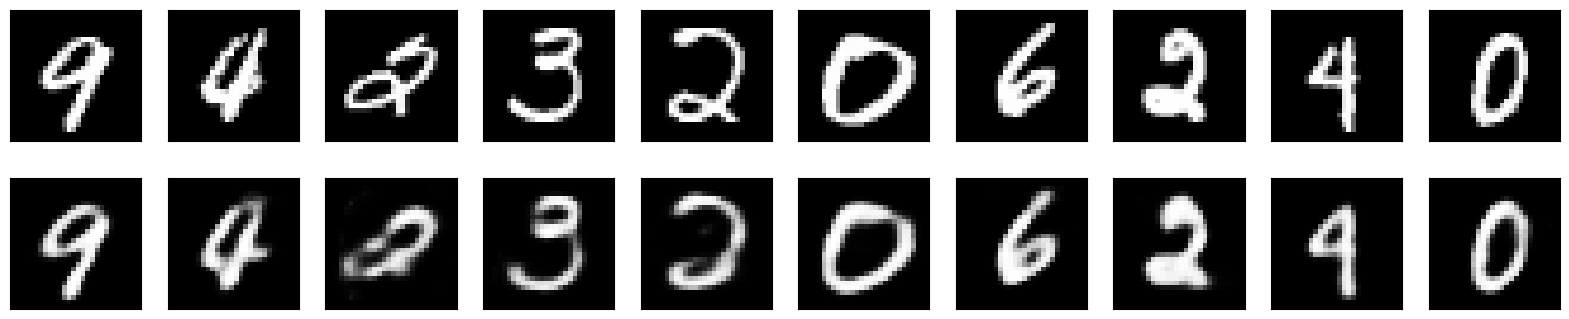

In [7]:
y_hat = trained_model.predict(x_test)

display_diff(x_test, y_hat['recon'])